In [1]:
import pandas as pd  
import matplotlib.pyplot as plt
from scipy import stats   
from lifelines import KaplanMeierFitter


In [2]:
# Install lifelines package
import subprocess
import sys

subprocess.check_call([sys.executable, "-m", "pip", "install", "lifelines"])

0

In [3]:
def load_and_summarize_data(file_path):
    """
    Load survival dataset and provide basic summary statistics.
    
    REASONING: Centralized data loading with immediate quality checks to catch 
    data issues early and understand the censoring pattern.
    
    Parameters:
    -----------
    file_path : str
        Path to the CSV file containing survival data
        
    Returns:
    --------
    pandas.DataFrame
        Loaded dataset with survival data
    """

    
    # Load data
    df = pd.read_csv(file_path)
    
    # Basic data summary
    print("Dataset Summary:")
    print(f"Total observations: {len(df):,}")
    print(f"Events observed: {df['event_observed'].sum():,}")
    print(f"Censored observations: {(df['event_observed'] == 0).sum():,}")
    print(f"Censoring rate: {(df['event_observed'] == 0).mean():.1%}")
    print(f"Follow-up time range: {df['time_to_event'].min():.1f} to {df['time_to_event'].max():.1f} years")
    
# Censoring informativeness check
    print("\nCensoring informativeness by covariates:")
    covariates = ['age_at_entry', 'income_level', 'health_score', 'pension_contrib_rate']
    
    for col in covariates:
        censored_mean = df[df['event_observed'] == 0][col].mean()
        event_mean = df[df['event_observed'] == 1][col].mean()
        diff = abs(censored_mean - event_mean)
        print(f"  {col}: Censored={censored_mean:.2f}, Events={event_mean:.2f}, Diff={diff:.2f}")
    
    return df







In [4]:
def create_survival_visualizations(df, save_plots=False):
    """
    Generate comprehensive survival analysis visualizations.
    
    REASONING: Visual exploration is essential for understanding survival patterns,
    censoring mechanisms, and covariate effects before formal modeling.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Survival dataset with required columns
    save_plots : bool, optional
        Whether to save plots as PNG files (default: False)
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    from lifelines import KaplanMeierFitter, NelsonAalenFitter
    from scipy import stats
    
    # Set plot style for consistency
    plt.style.use('default')
    
    # 1. Age vs Time scatter plot with censoring indication
    print("Generating visualization 1/5: Age vs Time relationship...")
    plt.figure(figsize=(10, 6))
    
    observed = df['event_observed'] == 1
    censored = df['event_observed'] == 0
    
    plt.scatter(df[observed]['age_at_entry'], df[observed]['time_to_event'], 
               alpha=0.6, s=15, color='red', label=f'Events (n={observed.sum()})')
    plt.scatter(df[censored]['age_at_entry'], df[censored]['time_to_event'], 
               alpha=0.6, s=15, color='blue', label=f'Censored (n={censored.sum()})')
    
    # Add trend line for events
    slope, intercept, r_value, _, _ = stats.linregress(
        df[observed]['age_at_entry'], df[observed]['time_to_event'])
    trend_line = slope * df['age_at_entry'] + intercept
    plt.plot(df['age_at_entry'], trend_line, 'black', linestyle='--', alpha=0.7, 
             label=f'Trend (R²={r_value**2:.3f})')
    
    plt.xlabel('Age at Entry (years)')
    plt.ylabel('Time to Event (years)')
    plt.title('Age at Entry vs Time to Event')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if save_plots:
        plt.savefig('age_vs_time.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Overall Kaplan-Meier survival curve
    print("Generating visualization 2/5: Overall survival curve...")
    km = KaplanMeierFitter()
    km.fit(df["time_to_event"], df["event_observed"])
    
    plt.figure(figsize=(8, 5))
    km.plot_survival_function(ci_show=True, color='blue')
    plt.title("Kaplan-Meier Overall Survival Curve")
    plt.xlabel("Time (years)")
    plt.ylabel("Survival Probability S(t)")
    plt.grid(True, alpha=0.3)
    
    # Add key statistics as text
    median_survival = km.median_survival_time_
    surv_10yr = km.predict(10) if 10 <= df['time_to_event'].max() else 'N/A'
    
    stats_text = f"Median survival: {median_survival:.1f} years"
    if surv_10yr != 'N/A':
        stats_text += f"\n10-year survival: {surv_10yr:.1%}"
    
    plt.text(0.02, 0.02, stats_text, transform=plt.gca().transAxes, 
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    if save_plots:
        plt.savefig('overall_survival.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Survival and cumulative incidence comparison
    print("Generating visualization 3/5: Survival vs cumulative incidence...")
    plt.figure(figsize=(9, 5))
    
    km.plot_survival_function(ci_show=False, color='blue', linewidth=2, label='Survival S(t)')
    
    cumulative_incidence = 1 - km.survival_function_
    plt.plot(cumulative_incidence.index, cumulative_incidence.values, 
             color='red', linewidth=2, label='Cumulative Incidence 1-S(t)')
    
    plt.title("Survival vs Cumulative Incidence")
    plt.xlabel("Time (years)")
    plt.ylabel("Probability")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    
    if save_plots:
        plt.savefig('survival_vs_incidence.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 4. Cumulative hazard function
    print("Generating visualization 4/5: Cumulative hazard...")
    naf = NelsonAalenFitter()
    naf.fit(df["time_to_event"], df["event_observed"])
    
    plt.figure(figsize=(8, 5))
    naf.plot(ci_show=True, color='green')
    plt.title("Nelson-Aalen Cumulative Hazard Function")
    plt.xlabel("Time (years)")
    plt.ylabel("Cumulative Hazard H(t)")
    plt.grid(True, alpha=0.3)
    
    if save_plots:
        plt.savefig('cumulative_hazard.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 5. Survival by covariate quartiles (income only for efficiency)
    print("Generating visualization 5/5: Survival by income quartiles...")
    df_temp = df.copy()
    df_temp['income_quartile'] = pd.qcut(df_temp['income_level'], 4, 
                                        labels=["Low", "Low-Mid", "Mid-High", "High"])
    
    plt.figure(figsize=(9, 6))
    
    colors = ['red', 'orange', 'blue', 'green']
    for i, (quartile, group_df) in enumerate(df_temp.groupby('income_quartile')):
        km_q = KaplanMeierFitter()
        km_q.fit(group_df["time_to_event"], group_df["event_observed"])
        km_q.plot_survival_function(ci_show=False, color=colors[i], 
                                   label=f"{quartile} Income (n={len(group_df)})")
    
    plt.title("Survival by Income Level Quartiles")
    plt.xlabel("Time (years)")
    plt.ylabel("Survival Probability S(t)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if save_plots:
        plt.savefig('survival_by_income.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("All visualizations completed successfully.")

Dataset Summary:
Total observations: 5,000
Events observed: 1,241
Censored observations: 3,759
Censoring rate: 75.2%
Follow-up time range: 0.1 to 18.9 years

Censoring informativeness by covariates:
  age_at_entry: Censored=40.62, Events=47.14, Diff=6.52
  income_level: Censored=42282.64, Events=33562.08, Diff=8720.55
  health_score: Censored=70.68, Events=67.50, Diff=3.18
  pension_contrib_rate: Censored=0.07, Events=0.08, Diff=0.01
Generating visualization 1/5: Age vs Time relationship...


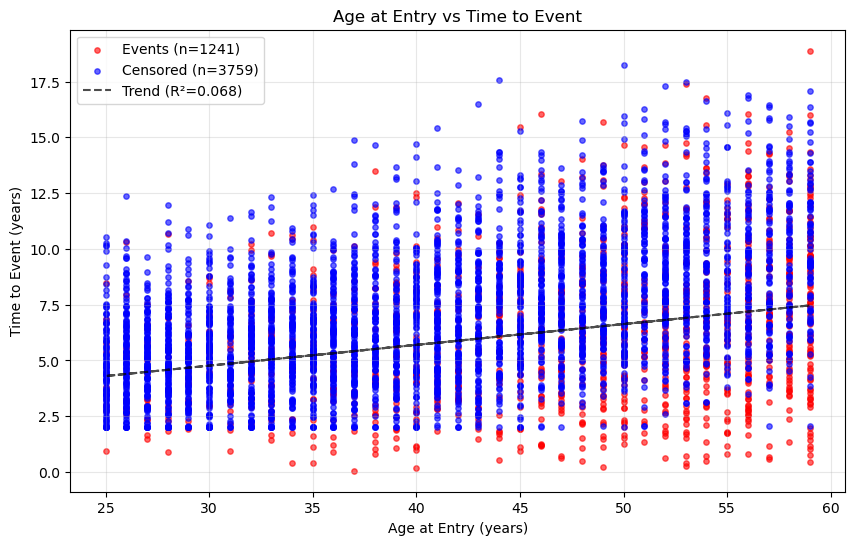

Generating visualization 2/5: Overall survival curve...


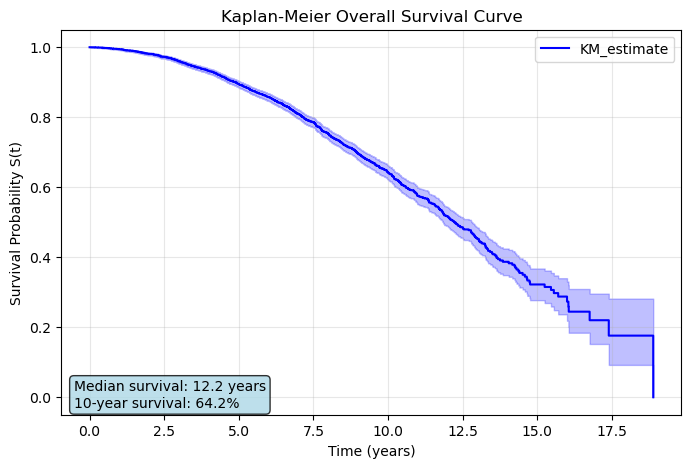

Generating visualization 3/5: Survival vs cumulative incidence...


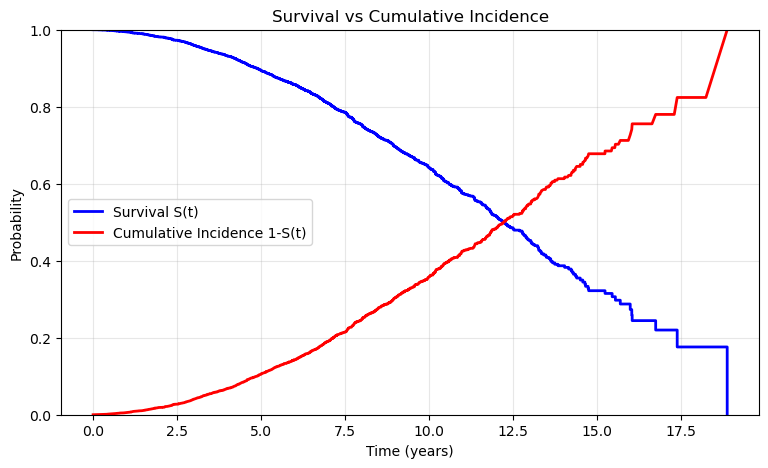

Generating visualization 4/5: Cumulative hazard...


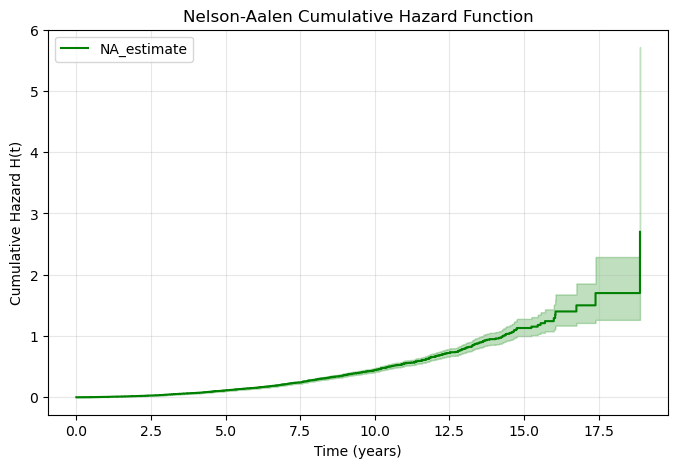

Generating visualization 5/5: Survival by income quartiles...


C:\Users\04ama\AppData\Local\Temp\ipykernel_12200\2629878430.py:125: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (quartile, group_df) in enumerate(df_temp.groupby('income_quartile')):


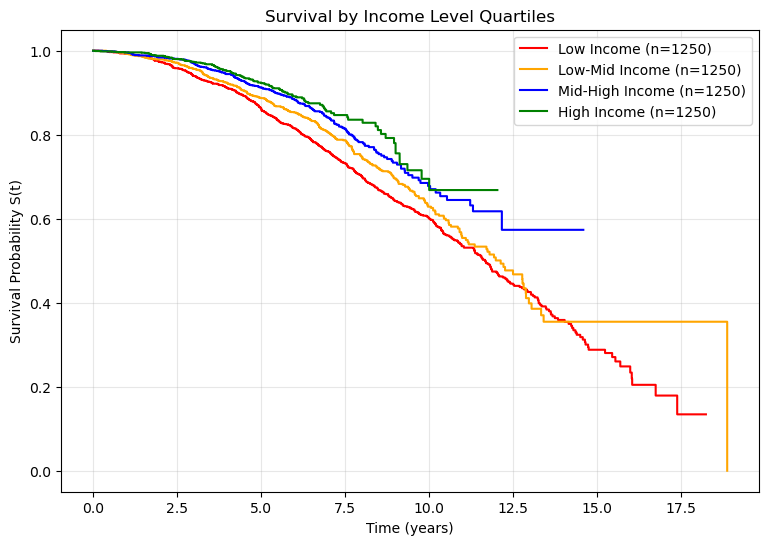

All visualizations completed successfully.


In [5]:

if __name__ == "__main__": #  for reusability as module
    # Load and summarize data
    file_path = "C:\\Users\\04ama\\OneDrive\\pension survival analysis\\notebooks\\Data generation\\synthetic_survival_data.csv"
    df = load_and_summarize_data(file_path)
    
    # Create visualizations
    create_survival_visualizations(df, save_plots=False)